# Lecture 12: Object Detection through Feature Matching

**Introduction:** Given a source image of an object, how can we detect that same object in a completely different target image, where the object might be translated, rotated, scaled, and captured under different lighting conditions? In this notebook, we will implement a simple method for detecting objects using *feature matching* (see image below). The method will make use of feature descriptors introduced in class, like [SIFT](https://www.researchgate.net/publication/235355151_Scale_Invariant_Feature_Transform) and [SURF](https://link.springer.com/chapter/10.1007/11744023_32), to detect and match 2D keypoints (i.e., feature correspondences) between the source and target image. Erroneous correspondences may arise due to imperfect feature descriptors, but we can surpress these outliers using [RANSAC](https://www.sciencedirect.com/science/article/pii/B9780080515816500702). At the end, we'll attempt to draw a bounding box around the target object in the target image.

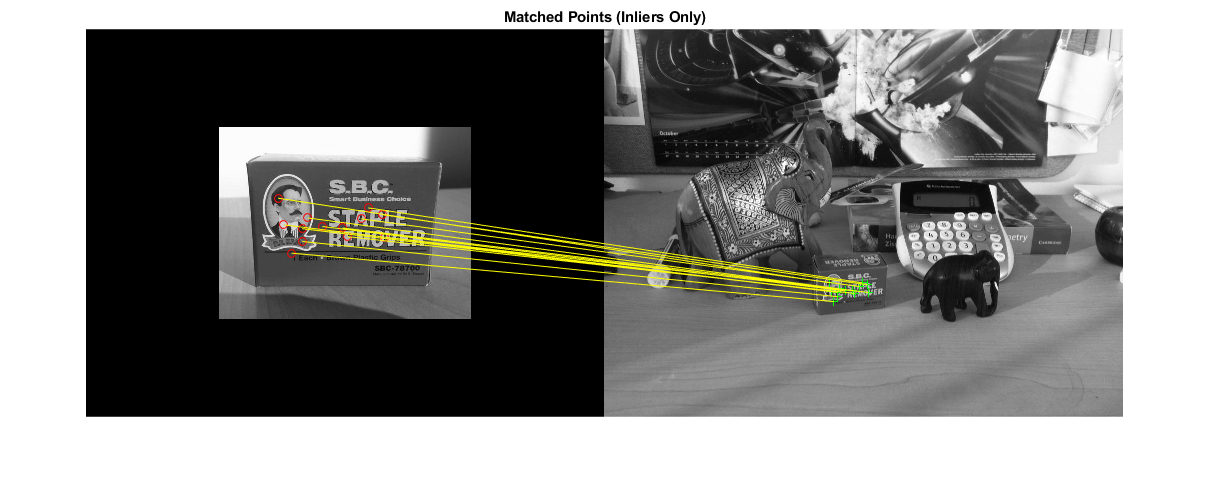

**Objective:** The goal of this notebook is to familiarize you with the detection and extraction of image features using descriptors, feature matching between images, and how outlier rejection strategies can be used to improve robustness in model fitting.

**Setup Instructions:** To run this notebook locally, please ensure the following dependencies are installed.
- System Dependencies: Python 3
- Python Packages: jupyter, numpy, opencv, matplotlib

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# To display images within Jupyter.
%matplotlib inline

# Load and plot source and target images.
img_dir = os.path.join(os.getcwd(), "lecture_12")

# Load source and target image.
# NOTE: Source image can be "elephant.jpg" or "staple.jpg".
src_img = cv2.imread(os.path.join(img_dir, "staple.jpg"), cv2.IMREAD_GRAYSCALE)
tar_img = cv2.imread(os.path.join(img_dir, "scene.jpg"), cv2.IMREAD_GRAYSCALE)

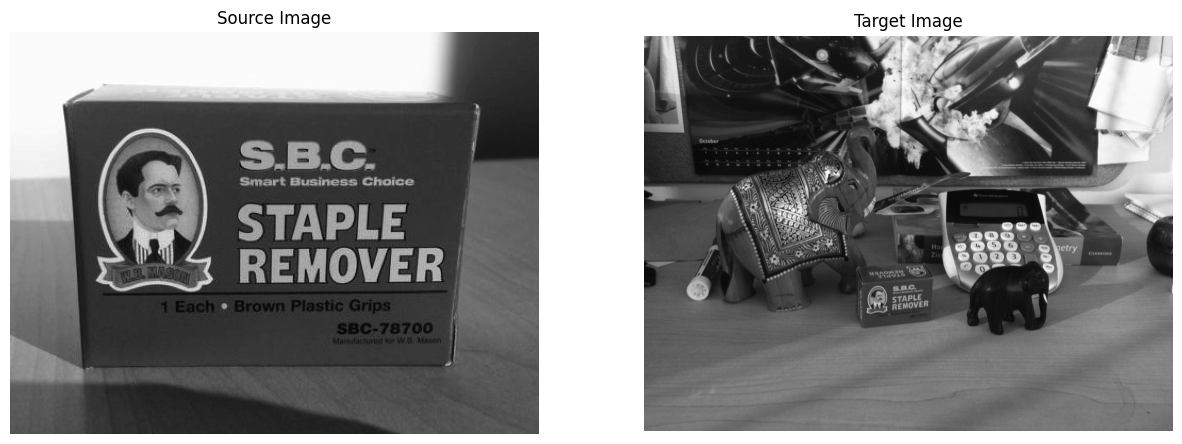

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
axes[0].imshow(src_img, cmap='gray')
axes[0].set_title('Source Image')
axes[0].set_axis_off()

axes[1].imshow(tar_img, cmap='gray')
axes[1].set_title('Target Image')
axes[1].set_axis_off()

## Step 1: Detect and extract SIFT features

In [13]:
# Initialize the SIFT detector.
sift = cv2.SIFT_create()

# Detect keypoints and extract their descriptors.
src_keypoints, src_descriptors = sift.detectAndCompute(src_img, None)
tar_keypoints, tar_descriptors = sift.detectAndCompute(tar_img, None)

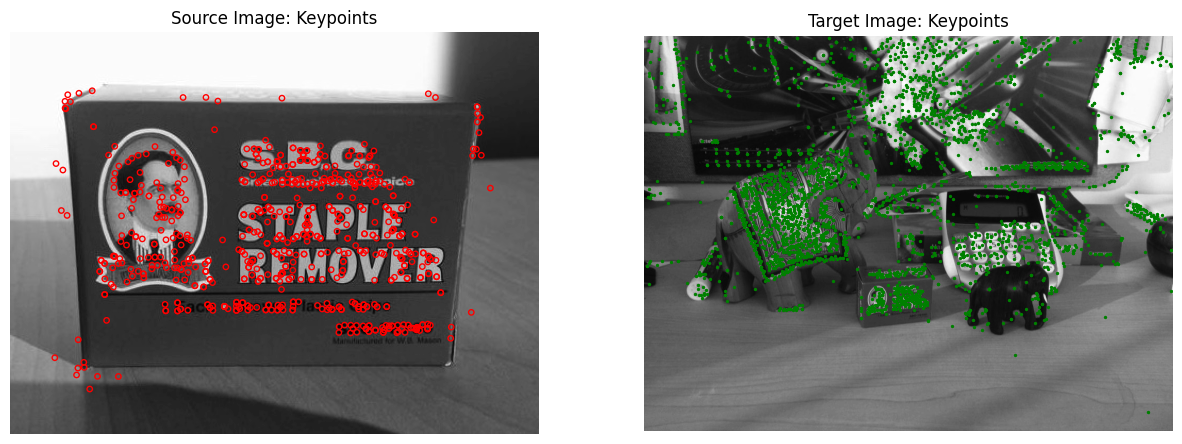

In [14]:
# Extract keypoints to numpy arrays.
src_pts = np.array([kp.pt for kp in src_keypoints])
tar_pts = np.array([kp.pt for kp in tar_keypoints])

fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
axes[0].imshow(src_img, cmap='gray')
axes[0].scatter(src_pts[:, 0], src_pts[:, 1], color='red', s=15, facecolor='none', marker='o')
axes[0].set_title('Source Image: Keypoints')
axes[0].set_axis_off()

axes[1].imshow(tar_img, cmap='gray')
axes[1].scatter(tar_pts[:, 0], tar_pts[:, 1], color='green', s=2)
axes[1].set_title('Target Image: Keypoints')
axes[1].set_axis_off()

## Step 2: Match ORB Features across images

In [15]:
# Create BFMatcher object with L2 norm (which is suitable for SIFT).
bf = cv2.BFMatcher(cv2.NORM_L2)

# Match descriptors and threshold based on L2 norm.
raw_matches = bf.knnMatch(src_descriptors, tar_descriptors, k=2)

# Apply ratio test to retain good matches.
# NOTE: try 0.5, or 0.75 as threshold values!
threshold = 0.9 
strong_matches = [m for m, n in raw_matches if m.distance < threshold * n.distance]

# Extract keypoints to numpy arrays.
src_pts_matched_unfiltered = np.array([src_keypoints[m.queryIdx].pt for m in strong_matches])
tar_pts_matched_unfiltered = np.array([tar_keypoints[m.trainIdx].pt for m in strong_matches])

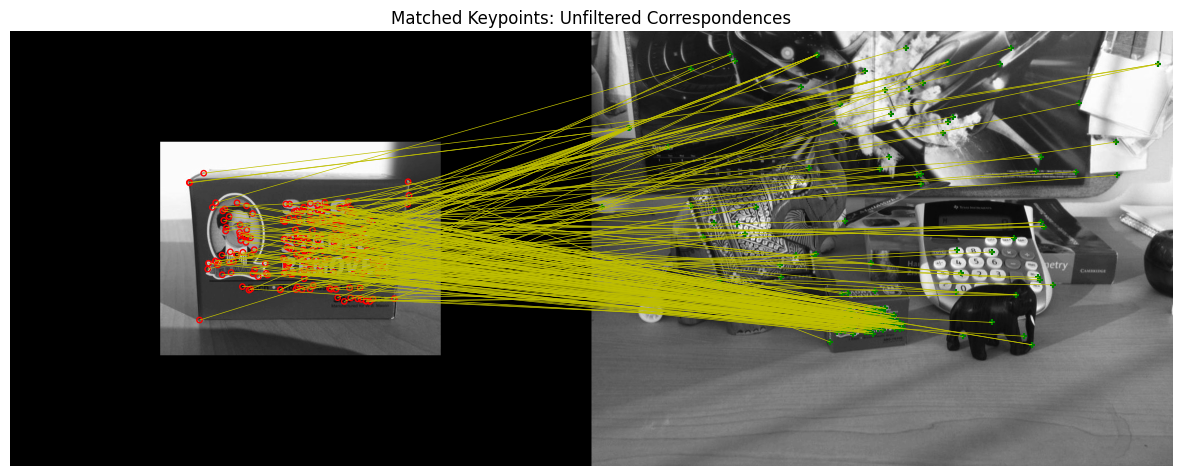

In [16]:
# Apply zero padding to the source image.
h_diff = tar_img.shape[0] - src_img.shape[0]
w_diff = tar_img.shape[1] - src_img.shape[1]
top, left = h_diff // 2, w_diff // 2
bottom, right = h_diff - top, w_diff - left
src_img_padded = cv2.copyMakeBorder(src_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

# Horizontally concatenate the images and shift matched points accordingly.
concat_img = np.hstack((src_img_padded, tar_img))
src_pts_plot = src_pts_matched_unfiltered + np.array([left, top])
tar_pts_plot = tar_pts_matched_unfiltered + np.array([src_img_padded.shape[1], 0])

# Display the concatenated image.
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.imshow(concat_img, cmap='gray')
ax.set_title('Matched Keypoints: Unfiltered Correspondences')
ax.set_axis_off()

# Plot lines between matched keypoints.
for i in range(len(src_pts_plot)):
    ax.plot(
        [src_pts_plot[i][0], tar_pts_plot[i][0]], 
        [src_pts_plot[i][1], tar_pts_plot[i][1]], 
        'y-', linewidth=0.5
    )
    
    # Plot starting point with a red "o".
    ax.scatter(
        src_pts_plot[i][0], 
        src_pts_plot[i][1], 
        color='red', 
        s=15, 
        facecolor='none', 
        marker='o'
    )
    
    # Plot ending point with a green "+".
    ax.scatter(
        tar_pts_plot[i][0], 
        tar_pts_plot[i][1], 
        color='green', 
        s=15, 
        marker='+'
    )

## Step 3: Estimate Homography \& Remove Outlier Feature Matches

In [17]:
# Use the RANSAC algorithm to find a good subset of feature matches.
homography, inliers = cv2.findHomography(
    src_pts_matched_unfiltered, 
    tar_pts_matched_unfiltered, 
    cv2.RANSAC, 
    5.0
)
matches_mask = inliers.squeeze().astype(bool)
src_pts_matched_ransac = src_pts_matched_unfiltered[matches_mask]
tar_pts_matched_ransac = tar_pts_matched_unfiltered[matches_mask]

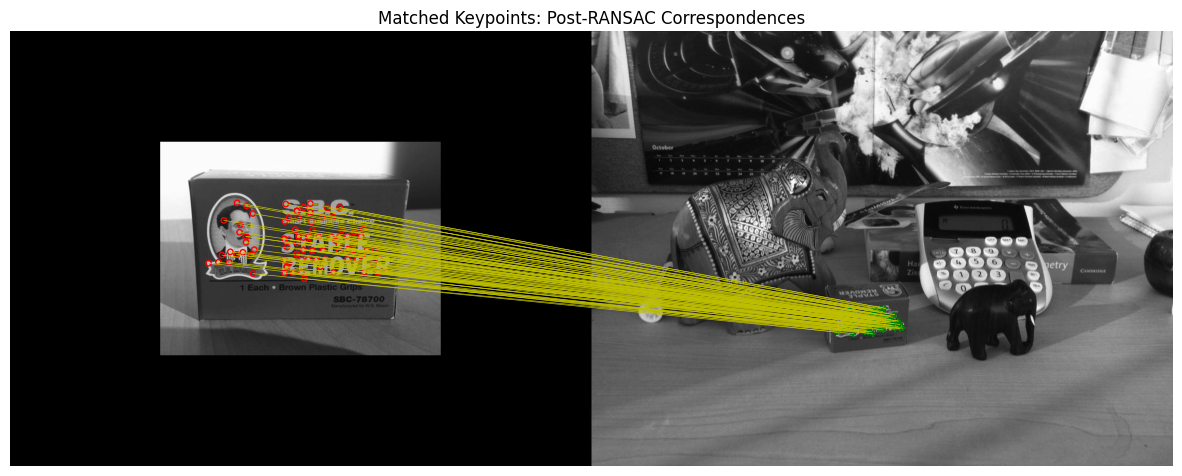

In [18]:
# Horizontally concatenate the images and shift matched points accordingly.
concat_img = np.hstack((src_img_padded, tar_img))
src_pts_plot = src_pts_matched_ransac + np.array([left, top])
tar_pts_plot = tar_pts_matched_ransac + np.array([src_img_padded.shape[1], 0])

# Display the concatenated image.
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.imshow(concat_img, cmap='gray')
ax.set_title('Matched Keypoints: Post-RANSAC Correspondences')
ax.set_axis_off()

# Plot lines between matched keypoints.
for i in range(len(src_pts_plot)):
    ax.plot(
        [src_pts_plot[i][0], tar_pts_plot[i][0]], 
        [src_pts_plot[i][1], tar_pts_plot[i][1]], 
        'y-', linewidth=0.5
    )
    
    # Plot starting point with a red "o".
    ax.scatter(
        src_pts_plot[i][0], 
        src_pts_plot[i][1], 
        color='red', 
        s=15, 
        facecolor='none', 
        marker='o'
    )
    
    # Plot ending point with a green "+".
    ax.scatter(
        tar_pts_plot[i][0], 
        tar_pts_plot[i][1], 
        color='green', 
        s=15, 
        marker='+'
    )

## Step 4: Project Bounding Box to Detect Objects

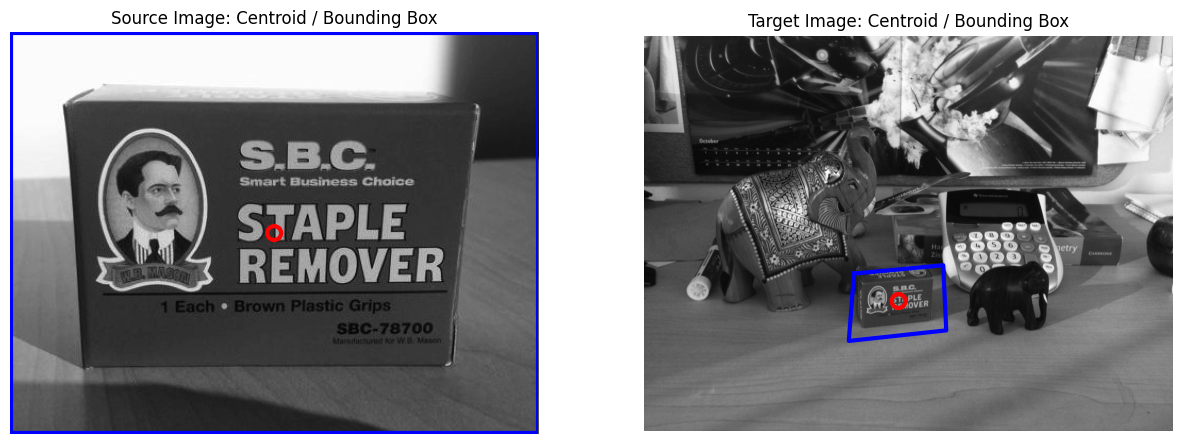

In [19]:
h, w = src_img.shape
src_bb_pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])
tar_bb_pts = cv2.perspectiveTransform(src_bb_pts.reshape(-1, 1, 2), homography).reshape(-1, 2)

# Predict centroid of object.
src_centroid_pt = np.mean(src_bb_pts, axis=0, keepdims=True)
tar_centroid_pt = cv2.perspectiveTransform(src_centroid_pt.reshape(-1, 1, 2), homography).reshape(-1, 2)

# Create a closed loop by appending the first point.
src_bb_pts_stacked = np.vstack([src_bb_pts, src_bb_pts[0]])
tar_bb_pts_stacked = np.vstack([tar_bb_pts, tar_bb_pts[0]])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))

axes[0].imshow(src_img, cmap='gray')
axes[0].plot(src_bb_pts_stacked[:, 0], src_bb_pts_stacked[:, 1], 'b-', linewidth=3)
axes[0].scatter(
    src_centroid_pt[0, 0],
    src_centroid_pt[0, 1],
    color='red',
    s=100,
    linewidth=3,
    facecolor='none',
    marker='o'
)
axes[0].set_title('Source Image: Centroid / Bounding Box')
axes[0].set_axis_off()

axes[1].imshow(tar_img, cmap='gray')
axes[1].plot(tar_bb_pts_stacked[:, 0], tar_bb_pts_stacked[:, 1], 'b-', linewidth=3)
axes[1].scatter(
    tar_centroid_pt[0, 0],
    tar_centroid_pt[0, 1],
    color='red',
    s=100,
    linewidth=3,
    facecolor='none',
    marker='o'
)
axes[1].set_title('Target Image: Centroid / Bounding Box')
axes[1].set_axis_off()
plt.show()